## Final Notebook - Hotel Customer Reviews Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wrangle
import unicodedata
from nltk.corpus import stopwords

### Project Overview:

- As the data science team at Bookings.com we analyzed the extensive customer review dataset for our partner hotels in the European region. Using natural language processing, sentiment analysis, and topic modeling we were able to identify key word and key topic drivers of reviewer’s score. Using reviewer’s scores we calculated current Net Promoter Scores for each hotel helping them understand their customer’s opinions so they can implement improvements based on the insight from our review analysis. 


### Project Goals:

- The goal of this project it to provide actionable recommendations to our partner hotels on how to increase their reviewer / NPS scores based on our findings from analyzing customer review data.


### Data Acquisition:

- The dataset was collected from kaggle where said data was scraped from Booking.com. This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe with positive and negative reviews along with other columns that contain features for exploration. A data dictionary can be found within the readme.md.


### Data Wrangling:

- This project required extensive data cleaning and wrangling including:

    - changing the column names to all lower case
    
    - parsing the list of strings in the tags column into seperate feature columns
    
    - changing the data type of the timestamp column and engineering additional features containing portions of the overall time stamp
    
    - verifying and updating review word counts
    
    - parsing the address values and creating seperate features for country, city, etc.
    
    - dropping unneeded columns
    
    - preparing the text data from NLP including basic clean, removing stopwords, and lemmatizing
    
    - changing the order of the columns within the dataframe 
    
    - cache the wrangled data as a csv to reduce processing time during exploration


In [2]:
df = wrangle.wrangle_hotel()
#df.info()
df.head(3)

Using cached csv file...


,month_name,month,year,day_name,day,quarter,hotel_name,street,city,zip_code,...,pos_sentiment_score,review_total_positive_word_counts,positive_unique_word_count,pos_lem_sentiment_score,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma
0,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,W2 1JU,...,0.4019,8,6,0.4019,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible
1,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,arr 75010,...,0.7906,7,6,0.7906,No Negative,NaN,NaN,very good location breakfast was great,good location breakfast great,good location breakfast great
2,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,1010,...,0.7579,7,6,0.7579,Nothing,NaN,NaN,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel


In [3]:
pos_dom_topics = pd.read_csv('dominant_topic.csv')
pos_dom_topics.rename(columns={'0':'positive_dominant_topic'}, inplace=True)
neg_dom_topics = pd.read_csv('negative_dominant_topic.csv')
neg_dom_topics.rename(columns={'0':'negative_dominant_topic'}, inplace=True)

In [4]:
df = pd.concat([df, pos_dom_topics.positive_dominant_topic, neg_dom_topics.negative_dominant_topic], axis=1)
df.head()

,month_name,month,year,day_name,day,quarter,hotel_name,street,city,zip_code,...,positive_unique_word_count,pos_lem_sentiment_score,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma,positive_dominant_topic,negative_dominant_topic
0,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,W2 1JU,...,6,0.4019,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible,8,4
1,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,arr 75010,...,6,0.7906,No Negative,NaN,NaN,very good location breakfast was great,good location breakfast great,good location breakfast great,9,0
2,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,1010,...,6,0.7579,Nothing,NaN,NaN,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel,9,0
3,August,8,2015,Tuesday,4,3,Novotel Amsterdam City,Europaboulevard 10 Zuideramstel,Amsterdam,1083 AD,...,23,0.9414,No Negative,NaN,NaN,Slightly out of the city center but very easy...,slightly city center easy get tram train reall...,slightly city center easy get tram train reall...,6,0
4,August,8,2015,Tuesday,4,3,Hilton London Kensington Hotel,Holland Park Avenue Kensington and Chelsea,London,W11 4UL,...,5,0.7964,No Negative,NaN,NaN,Great easy to reAch location,great easy reach location,great easy reach location,4,0


---

### Exploration - Dataset Breakdown

- The initial exploration of the dataset consisted of reviewing the distribution of customers across key groupings including trip type, group type and nights stayed as well as looking at reviewer score distributions and average hotel score distributions

<AxesSubplot:>

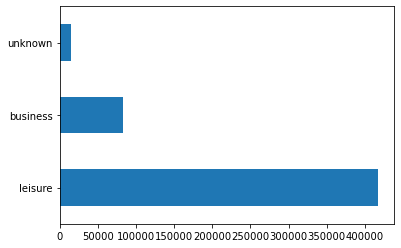

In [5]:
df.trip_type.value_counts().plot.barh()

<AxesSubplot:>

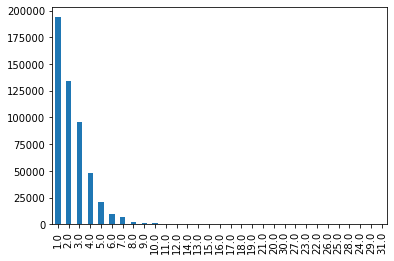

In [6]:
df.nights_stayed.value_counts().plot.bar()

<AxesSubplot:>

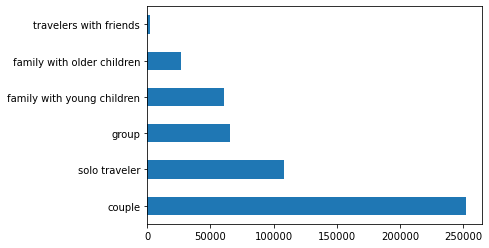

In [7]:
df.group_type.value_counts().plot.barh()

<AxesSubplot:ylabel='Frequency'>

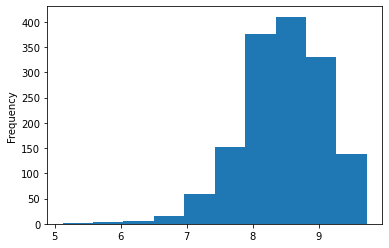

In [8]:
df.groupby(df.hotel_name).reviewer_score.mean().plot.hist()

---

### Exploration - Natural Language Processing

- After cleaning / wrangling the text data from the reviews we looked at most frequent unigrams, bigrams, trigram, etc from both the positive reviews and the negative reviews. 

In [10]:
df.positive_clean_review.fillna('', inplace=True)
df.negative_clean_review.fillna('', inplace=True)

pos_reviews = ' '.join(df.positive_clean_review)
pos_reviews = pos_reviews.split()

neg_reviews = ' '.join(df.negative_clean_review) 
neg_reviews = neg_reviews.split()

<AxesSubplot:>

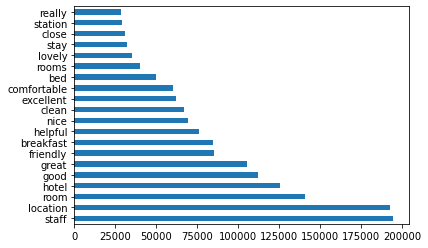

In [11]:
pd.Series(pos_reviews).value_counts().head(20).plot.barh()

<AxesSubplot:>

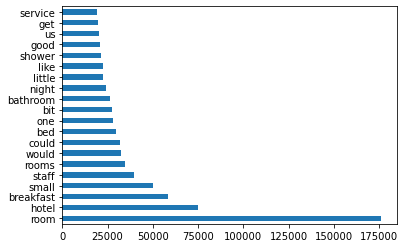

In [12]:
pd.Series(neg_reviews).value_counts().head(20).plot.barh()

In [13]:
#positive review bigrams
pos_bigrams = (pd.Series(nltk.ngrams(pos_reviews, 2)).value_counts().head(20))
pos_bigrams.head(20)

(great, location)        30992
(friendly, staff)        25238
(staff, friendly)        24828
(friendly, helpful)      21450
(good, location)         21091
(helpful, staff)         17820
(staff, helpful)         16788
(excellent, location)    12891
(location, great)        12811
(location, good)         11604
(location, staff)         9457
(breakfast, good)         9417
(good, breakfast)         9335
(comfortable, bed)        9006
(location, excellent)     8936
(staff, great)            8832
(room, clean)             8601
(walking, distance)       8406
(bed, comfortable)        7481
(helpful, friendly)       7368
dtype: int64

In [14]:
#negative review bigrams
neg_bigrams = (pd.Series(nltk.ngrams(neg_reviews, 2)).value_counts().head(20))
neg_bigrams.head(20)

(room, small)            9680
(room, service)          6330
(small, room)            6067
(air, conditioning)      5524
(booking, com)           4469
(star, hotel)            4000
(tea, coffee)            3948
(rooms, small)           3420
(4, star)                3234
(air, con)               3185
(breakfast, included)    3069
(even, though)           2972
(front, desk)            2914
(room, bit)              2827
(double, bed)            2821
(could, better)          2793
(little, bit)            2764
(bit, small)             2762
(would, nice)            2730
(mini, bar)              2723
dtype: int64

In [15]:
#positive review n-grams = 4
pos_quadgrams = (pd.Series(nltk.ngrams(pos_reviews, 4)).value_counts().head(20))
pos_quadgrams.head(20)

(great, location, friendly, staff)        1187
(location, friendly, helpful, staff)      1069
(friendly, staff, great, location)        1037
(staff, friendly, helpful, room)           830
(staff, friendly, helpful, location)       812
(friendly, staff, good, location)          745
(good, location, friendly, staff)          711
(helpful, staff, great, location)          683
(staff, extremely, friendly, helpful)      603
(location, staff, friendly, helpful)       568
(friendly, helpful, staff, great)          567
(friendly, helpful, staff, good)           541
(excellent, location, friendly, staff)     538
(hotel, staff, friendly, helpful)          508
(staff, really, friendly, helpful)         486
(staff, friendly, helpful, breakfast)      466
(friendly, helpful, staff, location)       444
(helpful, staff, good, location)           426
(friendly, staff, excellent, location)     425
(staff, friendly, helpful, hotel)          417
dtype: int64

In [16]:
#negative review n-grams = 4
neg_quadgrams = (pd.Series(nltk.ngrams(neg_reviews, 4)).value_counts().head(20))
neg_quadgrams.head(20)

(tea, coffee, making, facilities)     728
(coffee, making, facilities, room)    519
(tea, coffee, facilities, room)       370
(single, beds, pushed, together)      318
(tea, making, facilities, room)       218
(two, single, beds, pushed)           183
(room, little, bit, small)            171
(two, singles, pushed, together)      155
(bit, far, city, center)              124
(coffee, tea, making, facilities)     115
(breakfast, included, room, rate)     112
(2, single, beds, pushed)             109
(walls, thin, could, hear)            109
(room, little, small, side)           105
(room, two, single, beds)             102
(expect, 4, star, hotel)              100
(far, away, city, center)              88
(bit, far, city, centre)               87
(4, star, hotel, room)                 87
(tea, coffee, making, facility)        87
dtype: int64

---

In [17]:
df.group_type.value_counts()

couple                        252294
solo traveler                 108545
group                          65392
family with young children     61015
family with older children     26349
travelers with friends          2143
Name: group_type, dtype: int64

# Sentiment Intensity Analysis

### Sentiment Intensity scores are, in essence, calculated by the use of a comparison to a dictionary of positive and negative words. 
The scores range from -1 to 1, -1 being the most negative, and 1 being the most positive.

- Notable trends were found in the average sentiment intensity scores for trip type ('leisure', 'business', 'unknown') and group type ('couple', 'solo traveler', 'group', 'family with young children', 'family with older children', 'travelers with friends').
- Leisure travelers' average sentiment intensity scores were higher than those of the other two trip types.
- Solo travelers and families with young children tended to have lower average sentiment intensity scores than the other groups.
- Among the Net Promoter Score groups ('Detractor', 'Passive', 'Promoter'), of note is the 'Passive' group, whose average scores were higher than the other groups on negative reviews.


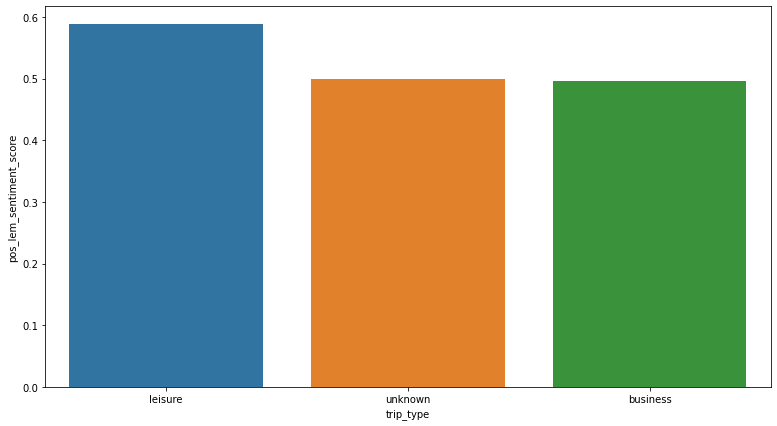

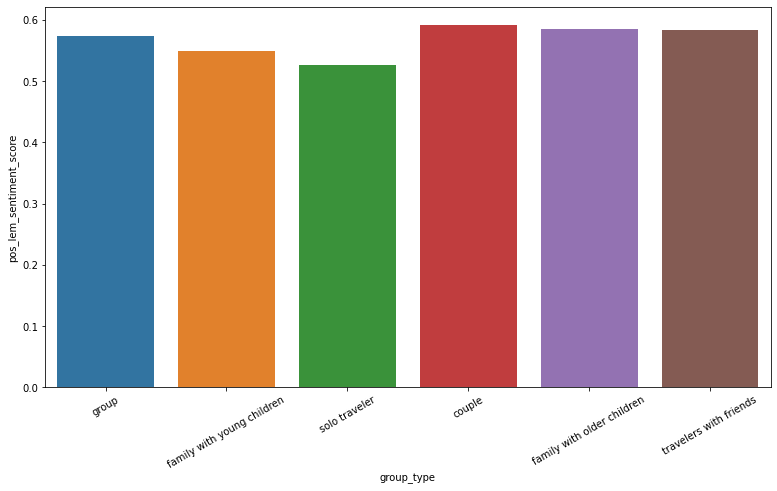

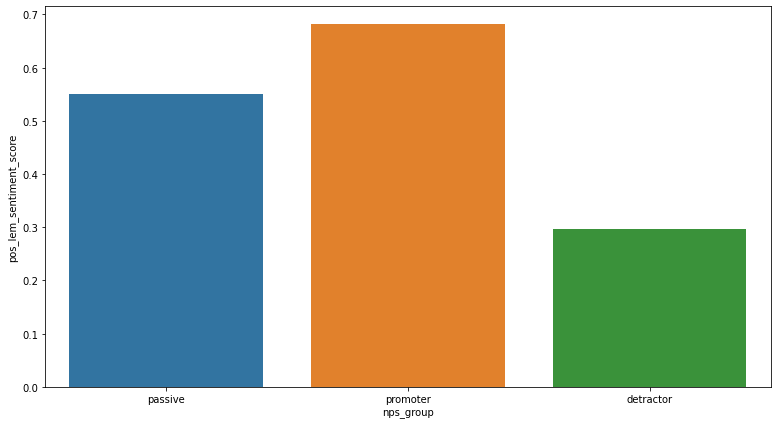

<AxesSubplot:xlabel='nps_group', ylabel='neg_lem_sentiment_score'>

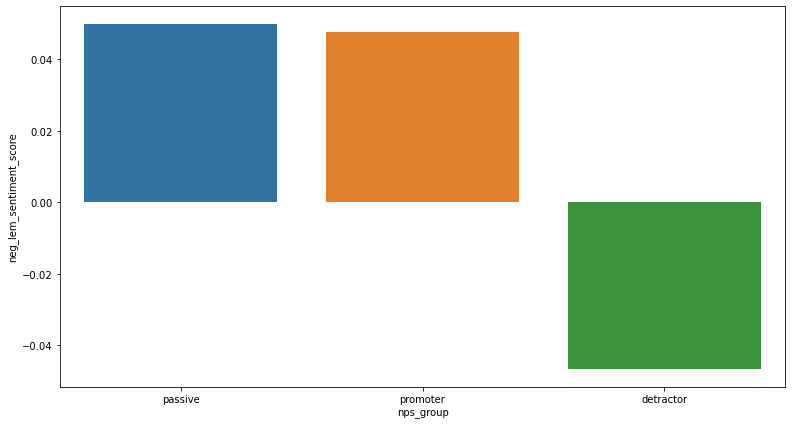

In [18]:
#Compare trip type and positive sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x= 'trip_type', y= 'pos_lem_sentiment_score', ci=False)
plt.show()

#Compare group type and positive sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x= 'group_type', y= 'pos_lem_sentiment_score', ci=False)
plt.xticks(rotation=30)
plt.show()

#Compare NPS group and positive sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x='nps_group', y='pos_lem_sentiment_score', ci=False)
plt.show()

#Compare NPS group and negative sentiment score
plt.figure(figsize=(13,7))
sns.barplot(data=df, x='nps_group', y='neg_lem_sentiment_score', ci=False)




# Topic Modeling 

- Notes..

In [26]:
pos_keywords = pd.read_csv('pos_topic_keyword.csv')
pos_keywords

,Unnamed: 0,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,Topic 0,room,bed,comfortable,clean,nice,comfy,bathroom,spacious,good,great,shower,big,size,large,really
1,Topic 1,staff,friendly,helpful,room,clean,breakfast,reception,modern,extremely,super,choice,pleasant,liked,kind,amazing
2,Topic 2,service,room,facility,coffee,excellent,tea,water,cleanliness,warm,birthday,upgrade,highly,food,overall,hot
3,Topic 3,room,lovely,hotel,view,nice,beautiful,quiet,like,great,bar,located,quite,floor,paris,restaurant
4,Topic 4,location,great,staff,excellent,friendly,hotel,perfect,helpful,amazing,check,fantastic,right,stay,polite,superb
5,Topic 5,hotel,stay,time,night,day,best,value,really,place,loved,pool,stayed,money,little,extra
6,Topic 6,close,station,hotel,city,easy,walking,train,distance,restaurant,centre,access,min,tram,tube,center
7,Topic 7,walk,minute,near,street,convenient,station,away,bus,stop,parking,quiet,tube,door,tower,air
8,Topic 8,hotel,restaurant,area,central,wonderful,lot,small,london,shop,transport,help,public,recommend,fabulous,needed
9,Topic 9,good,breakfast,location,nice,excellent,metro,food,hotel,price,quality,buffet,efficient,selection,really,trip


In [25]:
neg_keywords = pd.read_csv('negative_topic_keywords.csv')
neg_keywords

,Unnamed: 0,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,Topic 0,little,door,bit,hotel,double,problem,outside,london,car,friendly,extremely,tired,say,staff,need
1,Topic 1,room,coffee,tea,facility,walk,card,issue,table,smell,away,quality,look,station,paid,second
2,Topic 2,room,small,bathroom,view,shower,clean,toilet,wall,bit,size,tiny,light,space,dirty,towel
3,Topic 3,bed,bar,price,shower,water,area,star,hotel,bath,pillow,quite,uncomfortable,charged,glass,taxi
4,Topic 4,room,floor,hot,noise,poor,noisy,wifi,night,window,work,cold,open,free,slow,lift
5,Topic 5,breakfast,good,staff,great,service,really,ask,high,came,expected,choice,especially,english,like,restaurant
6,Topic 6,room,stay,hotel,night,check,time,reception,like,day,bed,parking,morning,sleep,pay,hard
7,Topic 7,hotel,location,got,old,far,city,single,way,good,hear,elevator,properly,corridor,fridge,disappointing
8,Topic 8,expensive,air,service,food,better,restaurant,hotel,pool,money,drink,conditioning,use,thing,need,nice
9,Topic 9,staff,room,hotel,booking,bad,booked,asked,working,told,said,desk,arrived,make,time,com


---

### Net Promoter Scores (NPS):

- NPS scores use reviewer's scores between 0 and 10 to classify each reviewer as either a 'promoter' (score of 9 or 10), a 'passive' (score of 7 or 8), or a 'detractor' (score of 6 or below).

- The NPS score for a hotel is calculted by taking the number of promoters minus the number of detractors divided by the total number of reviewers

In [21]:
def hotel_nps_score(series):
    score = ((series == 'promoter').sum() - (series == 'detractor').sum()) / series.size
    score = round(score * 100)
    return score

In [22]:
#calculate NPS scores for each hotel
hotel_df = pd.DataFrame(df.groupby(df.hotel_name).nps_group.apply(hotel_nps_score))
hotel_df.sort_values(by='nps_group', ascending=False)

,nps_group
hotel_name,
H10 Casa Mimosa 4 Sup,93
Ritz Paris,93
Hotel Casa Camper,93
The Soho Hotel,92
Bulgari Hotel London,92
...,...
Villa Eugenie,-52
Kube Hotel Ice Bar,-53
Savoy Hotel Amsterdam,-56


<AxesSubplot:ylabel='Frequency'>

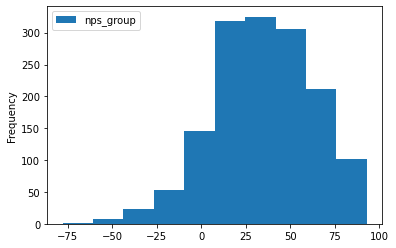

In [23]:
#Distribution of hotel NPS scores
hotel_df.plot.hist()

---

### Hotel Specific Data

- As an additional resource to our partner hotels we are providing hotel specific information from our analysis

- The dataframe below has nps score, average positive and negative sentiment scores, main topics and key words from positive reviews and main topisc and key words from negative reviews.

In [27]:
#Avg sentiment score of positive feedback by hotel
pos_sent = pd.DataFrame(df.groupby(df.hotel_name).pos_lem_sentiment_score.mean())
#avg sentiment score for negative feedback by hotel
neg_sent = pd.DataFrame(df.groupby(df.hotel_name).neg_lem_sentiment_score.mean())
#count of nps_group values
nps_type = pd.DataFrame(df.groupby(df.hotel_name).nps_group.value_counts()).unstack()
#pull top neg dominant topic by hotel
neg_dom_top = pd.DataFrame(df.groupby(df.hotel_name).negative_dominant_topic.agg(lambda hotel_topics: hotel_topics.value_counts().head(1).index))
#pull top pos dominant topic by hotel
pos_dom_top = pd.DataFrame(df.groupby(df.hotel_name).positive_dominant_topic.agg(lambda hotel_topics: hotel_topics.value_counts().head(1).index))
#concat the dfs
hotels = pd.concat([hotel_df, nps_type.nps_group.detractor, nps_type.nps_group.passive, nps_type.nps_group.promoter,
                    pos_sent.pos_lem_sentiment_score, neg_sent.neg_lem_sentiment_score, neg_dom_top.negative_dominant_topic,
                   pos_dom_top.positive_dominant_topic], axis=1)
#concat the keywords
cols = ['Word 0', 'Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5', 'Word 6', 'Word 7', 'Word 8', 'Word 9', 'Word 10', 'Word 11', 'Word 12', 'Word 13', 'Word 14']
n_words = pd.DataFrame(neg_keywords[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
p_words = pd.DataFrame(pos_keywords[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
#clean and merge with hotels df
n_words = n_words.reset_index()
n_words.rename(columns={0:'neg_keywords'}, inplace=True)
p_words = p_words.reset_index()
p_words.rename(columns={0:'pos_keywords'}, inplace=True)
hotels = hotels.merge(n_words, how='left', left_on='negative_dominant_topic', right_on='index')
hotels = hotels.merge(p_words, how='left', left_on='positive_dominant_topic', right_on='index')
hotels = hotels.drop(columns={'index_x', 'index_y'})
hotels.head()

,nps_group,detractor,passive,promoter,pos_lem_sentiment_score,neg_lem_sentiment_score,negative_dominant_topic,positive_dominant_topic,neg_keywords,pos_keywords
0,53,16.0,42.0,101.0,0.605062,0.010621,0,0,"little, door, bit, hotel, double, problem, out...","room, bed, comfortable, clean, nice, comfy, ba..."
1,9,34.0,66.0,48.0,0.543749,0.008590,0,0,"little, door, bit, hotel, double, problem, out...","room, bed, comfortable, clean, nice, comfy, ba..."
2,56,47.0,208.0,434.0,0.653845,0.048747,0,4,"little, door, bit, hotel, double, problem, out...","location, great, staff, excellent, friendly, h..."
3,91,2.0,5.0,96.0,0.685737,0.039544,0,5,"little, door, bit, hotel, double, problem, out...","hotel, stay, time, night, day, best, value, re..."
4,86,NaN,4.0,24.0,0.503500,0.074264,0,1,"little, door, bit, hotel, double, problem, out...","staff, friendly, helpful, room, clean, breakfa..."


---

### Summary

Overall Findings:

   - 49% of all reviewers were couples
   
   - 81% of all reviewers were on a leisure trip
   
   - 95% of all reviewers stayed for five or less nights
   
   - Top 5 positive unigrams are - staff, location, room, hotel, good
   
   - Top 5 negative ungrams are - room, hotel, breakfast, small, staff
   
   - Top positive topic is - 
   
   - Top negative topic is - 
    
Hotel Specific Findings:

   - The average hotel NPS score is 34
   
   - The max hotel NPS score is 93
    
   - The minimum hotel NPS score is -78
    

### Recommendations

- Each hotel should look over their individual information in the 'hotels' table.

- 'XXXXXX' were noted as overall primary positive topics and each hotel should focus on highlighting their 'XXXXXX' in marketing and customer interactions

- 'XXXXXX' were noted as overall primary negative topics and each hotel should evaluate how these issues affect their property

- If your hotel has an NPS score of higher than 50 you should focus on maintaining your performance in areas noted as 'primary positive topics' 

- If your hotel has an NPS score less than 50 you should focus on addressing issues noted as 'primary negative topics'